In [31]:
!pip install optuna xgboost lightgbm "mlflow<3" python-dotenv joblib

In [32]:

base_folder = "/Users/chengxiaowei/Desktop/Python/eas503/Xiaowei_finalProject"
%cd "{base_folder}"

/Users/chengxiaowei/Desktop/Python/eas503/Xiaowei_finalProject


In [33]:
import sqlite3
import pandas as pd

db_path = f"{base_folder}/xiaowei_data/flightdelays.db"   # <<< 改成你的db位置
conn = sqlite3.connect(db_path)

df = pd.read_sql_query(
    """
    SELECT
      f.flight_id,
      f.date,
      f.schedtime,
      f.deptime,
      f.distance,
      f.flightnumber,
      f.weather,
      f.dayweek,
      f.daymonth,
      c.code AS carrier,
      a1.code AS origin,
      a2.code AS dest,
      t.tailnu AS tailnu,
      f.delay
    FROM flight f
    JOIN dim_carrier c ON f.carrier_id = c.carrier_id
    JOIN dim_airport a1 ON f.origin_airport_id = a1.airport_id
    JOIN dim_airport a2 ON f.dest_airport_id = a2.airport_id
    JOIN dim_tail t ON f.tail_id = t.tail_id
    ORDER BY f.flight_id
    """,
    conn,
)
conn.close()

df.head()


,flight_id,date,schedtime,deptime,distance,flightnumber,weather,dayweek,daymonth,carrier,origin,dest,tailnu,delay
0,0,1/1/2004,1455,1455,184,5935,0,4,1,OH,BWI,JFK,N940CA,ontime
1,1,1/1/2004,1640,1640,213,6155,0,4,1,DH,DCA,JFK,N405FJ,ontime
2,2,1/1/2004,1245,1245,229,7208,0,4,1,DH,IAD,LGA,N695BR,ontime
3,3,1/1/2004,1715,1709,229,7215,0,4,1,DH,IAD,LGA,N662BR,ontime
4,4,1/1/2004,1039,1035,229,7792,0,4,1,DH,IAD,LGA,N698BR,ontime


In [34]:
import time
import os
import numpy as np

from dotenv import load_dotenv

from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler

from sklearn.linear_model import RidgeClassifier
from sklearn.ensemble import HistGradientBoostingClassifier

import mlflow
from mlflow.models import infer_signature
import joblib

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

import optuna
from optuna.samplers import TPESampler
from sklearn.base import clone

from flightdelays_pipeline import build_preprocessing, make_estimator_for_name

start_time = time.monotonic()
optuna.logging.set_verbosity(optuna.logging.WARNING)
RANDOM_STATE = 42


In [35]:
preprocessing = build_preprocessing()
print("✓ STEP 1: Preprocessing pipeline created.")


✓ STEP 1: Preprocessing pipeline created.


In [36]:
# y: delayed=1, ontime=0
y = df["delay"].map({"ontime": 0, "delayed": 1}).astype(int)

X = df[
    ["schedtime", "distance", "weather", "dayweek", "daymonth", "flightnumber",
     "carrier", "origin", "dest"]
].copy()

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.20,
    stratify=y,
    random_state=RANDOM_STATE
)

print(f"✓ STEP 2: Stratified split done. Train size: {len(X_train)}, Test size: {len(X_test)}")
print("Class balance:", y.value_counts().to_dict())


✓ STEP 2: Stratified split done. Train size: 1760, Test size: 441
Class balance: {0: 1773, 1: 428}


In [37]:
load_dotenv(dotenv_path=f"{base_folder}/xiaowei_notebooks/.env", override=True)
MLFLOW_TRACKING_URI = os.getenv("MLFLOW_TRACKING_URI")
MLFLOW_TRACKING_USERNAME = os.getenv("MLFLOW_TRACKING_USERNAME")
MLFLOW_TRACKING_PASSWORD = os.getenv("MLFLOW_TRACKING_PASSWORD")
if MLFLOW_TRACKING_USERNAME: os.environ["MLFLOW_TRACKING_USERNAME"] = MLFLOW_TRACKING_USERNAME
if MLFLOW_TRACKING_PASSWORD: os.environ["MLFLOW_TRACKING_PASSWORD"] = MLFLOW_TRACKING_PASSWORD
if MLFLOW_TRACKING_URI: mlflow.set_tracking_uri(MLFLOW_TRACKING_URI)

mlflow.set_experiment("flightdelays_multi_model_optuna")
print("✓ STEP 3: MLflow configured.")


2025/12/18 14:09:51 INFO mlflow.tracking.fluent: Experiment with name 'flightdelays_multi_model_optuna' does not exist. Creating a new experiment.


✓ STEP 3: MLflow configured.


In [38]:
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE)

def objective_ridge(trial, preprocessing, X_train, y_train):
    alpha = trial.suggest_float("ridge__alpha", 0.1, 100.0, log=True)
    preprocessing_clone = clone(preprocessing)
    pipeline = make_pipeline(preprocessing_clone, RidgeClassifier(alpha=alpha, class_weight="balanced"))
    scores = cross_val_score(pipeline, X_train, y_train, cv=cv, scoring="f1", n_jobs=-1)
    return scores.mean()  # maximize


def objective_hgb(trial, preprocessing, X_train, y_train):
    learning_rate = trial.suggest_float("hgb__learning_rate", 0.02, 0.3, log=True)
    max_depth = trial.suggest_int("hgb__max_depth", 2, 10)
    preprocessing_clone = clone(preprocessing)
    pipeline = make_pipeline(
        preprocessing_clone,
        HistGradientBoostingClassifier(
            learning_rate=learning_rate,
            max_depth=max_depth,
            random_state=RANDOM_STATE
        )
    )
    scores = cross_val_score(pipeline, X_train, y_train, cv=cv, scoring="f1", n_jobs=-1)
    return scores.mean()


def objective_xgb(trial, preprocessing, X_train, y_train):
    learning_rate = trial.suggest_float("xgb__learning_rate", 0.01, 0.3, log=True)
    max_depth = trial.suggest_int("xgb__max_depth", 2, 10)
    n_estimators = trial.suggest_int("xgb__n_estimators", 200, 1200, step=100)
    subsample = trial.suggest_float("xgb__subsample", 0.6, 1.0)
    colsample = trial.suggest_float("xgb__colsample_bytree", 0.6, 1.0)

    preprocessing_clone = clone(preprocessing)
    pipeline = make_pipeline(
        preprocessing_clone,
        XGBClassifier(
            random_state=RANDOM_STATE,
            n_estimators=n_estimators,
            learning_rate=learning_rate,
            max_depth=max_depth,
            subsample=subsample,
            colsample_bytree=colsample,
            eval_metric="logloss",
            tree_method="hist",
            n_jobs=-1,
        )
    )
    scores = cross_val_score(pipeline, X_train, y_train, cv=cv, scoring="f1", n_jobs=-1)
    return scores.mean()


def objective_lgbm(trial, preprocessing, X_train, y_train):
    learning_rate = trial.suggest_float("lgbm__learning_rate", 0.01, 0.3, log=True)
    num_leaves = trial.suggest_int("lgbm__num_leaves", 15, 255)
    n_estimators = trial.suggest_int("lgbm__n_estimators", 200, 2000, step=200)

    preprocessing_clone = clone(preprocessing)
    pipeline = make_pipeline(
        preprocessing_clone,
        LGBMClassifier(
            random_state=RANDOM_STATE,
            n_estimators=n_estimators,
            learning_rate=learning_rate,
            num_leaves=num_leaves,
            n_jobs=-1,
            verbose=-1,
        )
    )
    scores = cross_val_score(pipeline, X_train, y_train, cv=cv, scoring="f1", n_jobs=-1)
    return scores.mean()


In [39]:
model_names = ["ridge", "histgradientboosting", "xgboost", "lightgbm"]
objective_functions = {
    "ridge": objective_ridge,
    "histgradientboosting": objective_hgb,
    "xgboost": objective_xgb,
    "lightgbm": objective_lgbm,
}

results = {}

for name in model_names:
    print(f"\n{'='*80}")
    print(f"Optimizing {name.upper()} (NO PCA) - 10 trials")
    print(f"{'='*80}")

    study = optuna.create_study(
        direction="maximize",
        sampler=TPESampler(seed=RANDOM_STATE),
        study_name=f"{name}_study"
    )

    study.optimize(
        lambda trial: objective_functions[name](trial, preprocessing, X_train, y_train),
        n_trials=10,
        show_progress_bar=True
    )

    cv_f1 = float(study.best_value)
    best_params = study.best_params

    print(f"\nBest {name.upper()} CV F1: {cv_f1:.4f}")
    print(f"Best params: {best_params}")

    preprocessing_clone = clone(preprocessing)

    if name == "ridge":
        final_model = make_pipeline(preprocessing_clone, RidgeClassifier(alpha=best_params["ridge__alpha"], class_weight="balanced"))
    elif name == "histgradientboosting":
        final_model = make_pipeline(
            preprocessing_clone,
            HistGradientBoostingClassifier(
                learning_rate=best_params["hgb__learning_rate"],
                max_depth=best_params["hgb__max_depth"],
                random_state=RANDOM_STATE
            )
        )
    elif name == "xgboost":
        final_model = make_pipeline(
            preprocessing_clone,
            XGBClassifier(
                random_state=RANDOM_STATE,
                n_estimators=best_params["xgb__n_estimators"],
                learning_rate=best_params["xgb__learning_rate"],
                max_depth=best_params["xgb__max_depth"],
                subsample=best_params["xgb__subsample"],
                colsample_bytree=best_params["xgb__colsample_bytree"],
                eval_metric="logloss",
                tree_method="hist",
                n_jobs=-1,
            )
        )
    elif name == "lightgbm":
        final_model = make_pipeline(
            preprocessing_clone,
            LGBMClassifier(
                random_state=RANDOM_STATE,
                n_estimators=best_params["lgbm__n_estimators"],
                learning_rate=best_params["lgbm__learning_rate"],
                num_leaves=best_params["lgbm__num_leaves"],
                n_jobs=-1,
                verbose=-1,
            )
        )

    final_model.fit(X_train, y_train)
    y_pred = final_model.predict(X_test)
    test_f1 = float(f1_score(y_test, y_pred))

    print(f"{name} (no PCA) Test F1: {test_f1:.4f}")

    results[name] = {"pipeline": final_model, "test_f1": test_f1, "cv_f1": cv_f1}

    with mlflow.start_run(run_name=f"{name}_baseline_optuna"):
        mlflow.log_param("model_family", name)
        mlflow.log_param("uses_pca", False)
        mlflow.log_params(best_params)
        mlflow.log_metric("cv_F1", cv_f1)
        mlflow.log_metric("test_F1", test_f1)

        signature = infer_signature(X_train, final_model.predict(X_train))
        mlflow.sklearn.log_model(
            sk_model=final_model,
            artifact_path="flightdelays_model",
            signature=signature,
            input_example=X_train,
            registered_model_name=f"{name}_pipeline_optuna",
        )

print("\n✓ STEP 5: All 4 baseline models optimized and logged.")



Optimizing RIDGE (NO PCA) - 10 trials


  0%|          | 0/10 [00:00<?, ?it/s]


Best RIDGE CV F1: 0.4027
Best params: {'ridge__alpha': 0.14936568554617632}
ridge (no PCA) Test F1: 0.3438


/opt/anaconda3/lib/python3.13/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
Successfully registered model 'ridge_pipeline_optuna'.
2025/12/18 14:10:05 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: ridge_pipeline_optuna, version 1
Created ver

🏃 View run ridge_baseline_optuna at: https://dagshub.com/xiaowei251129/xiaowei_finalproject.mlflow/#/experiments/2/runs/30fd878952e94ad6a982fe8fcf0500ff
🧪 View experiment at: https://dagshub.com/xiaowei251129/xiaowei_finalproject.mlflow/#/experiments/2

Optimizing HISTGRADIENTBOOSTING (NO PCA) - 10 trials


  0%|          | 0/10 [00:00<?, ?it/s]


Best HISTGRADIENTBOOSTING CV F1: 0.4291
Best params: {'hgb__learning_rate': 0.10185822566867639, 'hgb__max_depth': 8}
histgradientboosting (no PCA) Test F1: 0.4375


/opt/anaconda3/lib/python3.13/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
Successfully registered model 'histgradientboosting_pipeline_optuna'.
2025/12/18 14:10:24 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: histgradientboosting_pipeline

🏃 View run histgradientboosting_baseline_optuna at: https://dagshub.com/xiaowei251129/xiaowei_finalproject.mlflow/#/experiments/2/runs/5e00807c3fc94b02a87bd80742ab5c85
🧪 View experiment at: https://dagshub.com/xiaowei251129/xiaowei_finalproject.mlflow/#/experiments/2

Optimizing XGBOOST (NO PCA) - 10 trials


  0%|          | 0/10 [00:00<?, ?it/s]


Best XGBOOST CV F1: 0.4664
Best params: {'xgb__learning_rate': 0.09519754482692679, 'xgb__max_depth': 4, 'xgb__n_estimators': 700, 'xgb__subsample': 0.8186841117373118, 'xgb__colsample_bytree': 0.6739417822102108}
xgboost (no PCA) Test F1: 0.4805


/opt/anaconda3/lib/python3.13/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
Successfully registered model 'xgboost_pipeline_optuna'.
2025/12/18 14:10:45 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: xgboost_pipeline_optuna, version 1
Created

🏃 View run xgboost_baseline_optuna at: https://dagshub.com/xiaowei251129/xiaowei_finalproject.mlflow/#/experiments/2/runs/7fd8a2db153a451796d0216bb1ff47a1
🧪 View experiment at: https://dagshub.com/xiaowei251129/xiaowei_finalproject.mlflow/#/experiments/2

Optimizing LIGHTGBM (NO PCA) - 10 trials


  0%|          | 0/10 [00:00<?, ?it/s]

/opt/anaconda3/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.13/


Best LIGHTGBM CV F1: 0.4563
Best params: {'lgbm__learning_rate': 0.07661100707771368, 'lgbm__num_leaves': 52, 'lgbm__n_estimators': 400}


/opt/anaconda3/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


lightgbm (no PCA) Test F1: 0.4706


/opt/anaconda3/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/sklear

🏃 View run lightgbm_baseline_optuna at: https://dagshub.com/xiaowei251129/xiaowei_finalproject.mlflow/#/experiments/2/runs/7bca0b459c2c440aa6f9e2b1aac52786
🧪 View experiment at: https://dagshub.com/xiaowei251129/xiaowei_finalproject.mlflow/#/experiments/2

✓ STEP 5: All 4 baseline models optimized and logged.


In [40]:
def objective_ridge_pca(trial, preprocessing, X_train, y_train):
    alpha = trial.suggest_float("ridge__alpha", 0.1, 100.0, log=True)
    pca_components = trial.suggest_float("pca__n_components", 0.90, 0.99)
    preprocessing_clone = clone(preprocessing)
    pipeline = make_pipeline(preprocessing_clone, PCA(n_components=pca_components), RidgeClassifier(alpha=alpha, class_weight="balanced"))
    scores = cross_val_score(pipeline, X_train, y_train, cv=cv, scoring="f1", n_jobs=-1)
    return scores.mean()

def objective_hgb_pca(trial, preprocessing, X_train, y_train):
    learning_rate = trial.suggest_float("hgb__learning_rate", 0.02, 0.3, log=True)
    max_depth = trial.suggest_int("hgb__max_depth", 2, 10)
    pca_components = trial.suggest_float("pca__n_components", 0.90, 0.99)
    preprocessing_clone = clone(preprocessing)
    pipeline = make_pipeline(
        preprocessing_clone,
        PCA(n_components=pca_components),
        HistGradientBoostingClassifier(
            learning_rate=learning_rate, max_depth=max_depth, random_state=RANDOM_STATE
        )
    )
    scores = cross_val_score(pipeline, X_train, y_train, cv=cv, scoring="f1", n_jobs=-1)
    return scores.mean()

def objective_xgb_pca(trial, preprocessing, X_train, y_train):
    learning_rate = trial.suggest_float("xgb__learning_rate", 0.01, 0.3, log=True)
    max_depth = trial.suggest_int("xgb__max_depth", 2, 10)
    n_estimators = trial.suggest_int("xgb__n_estimators", 200, 1200, step=100)
    subsample = trial.suggest_float("xgb__subsample", 0.6, 1.0)
    colsample = trial.suggest_float("xgb__colsample_bytree", 0.6, 1.0)
    pca_components = trial.suggest_float("pca__n_components", 0.90, 0.99)

    preprocessing_clone = clone(preprocessing)
    pipeline = make_pipeline(
        preprocessing_clone,
        PCA(n_components=pca_components),
        XGBClassifier(
            random_state=RANDOM_STATE,
            n_estimators=n_estimators,
            learning_rate=learning_rate,
            max_depth=max_depth,
            subsample=subsample,
            colsample_bytree=colsample,
            eval_metric="logloss",
            tree_method="hist",
            n_jobs=-1,
        )
    )
    scores = cross_val_score(pipeline, X_train, y_train, cv=cv, scoring="f1", n_jobs=-1)
    return scores.mean()

def objective_lgbm_pca(trial, preprocessing, X_train, y_train):
    learning_rate = trial.suggest_float("lgbm__learning_rate", 0.01, 0.3, log=True)
    num_leaves = trial.suggest_int("lgbm__num_leaves", 15, 255)
    n_estimators = trial.suggest_int("lgbm__n_estimators", 200, 2000, step=200)
    pca_components = trial.suggest_float("pca__n_components", 0.90, 0.99)

    preprocessing_clone = clone(preprocessing)
    pipeline = make_pipeline(
        preprocessing_clone,
        PCA(n_components=pca_components),
        LGBMClassifier(
            random_state=RANDOM_STATE,
            n_estimators=n_estimators,
            learning_rate=learning_rate,
            num_leaves=num_leaves,
            n_jobs=-1,
            verbose=-1,
        )
    )
    scores = cross_val_score(pipeline, X_train, y_train, cv=cv, scoring="f1", n_jobs=-1)
    return scores.mean()


In [41]:
pca_model_names = ["ridge_with_pca", "histgradientboosting_with_pca", "xgboost_with_pca", "lightgbm_with_pca"]
pca_objective_functions = {
    "ridge_with_pca": objective_ridge_pca,
    "histgradientboosting_with_pca": objective_hgb_pca,
    "xgboost_with_pca": objective_xgb_pca,
    "lightgbm_with_pca": objective_lgbm_pca,
}

pca_results = {}

for name in pca_model_names:
    base_name = name.replace("_with_pca", "")
    print(f"\n{'='*80}")
    print(f"Optimizing {name.upper()} - 10 trials")
    print(f"{'='*80}")

    study = optuna.create_study(
        direction="maximize",
        sampler=TPESampler(seed=RANDOM_STATE),
        study_name=f"{name}_study"
    )

    study.optimize(
        lambda trial: pca_objective_functions[name](trial, preprocessing, X_train, y_train),
        n_trials=10,
        show_progress_bar=True
    )

    cv_f1 = float(study.best_value)
    best_params = study.best_params

    print(f"\nBest {name.upper()} CV F1: {cv_f1:.4f}")
    print(f"Best params: {best_params}")

    preprocessing_clone = clone(preprocessing)
    pca_n = best_params["pca__n_components"]

    if base_name == "ridge":
        final_model = make_pipeline(preprocessing_clone, PCA(n_components=pca_n), RidgeClassifier(alpha=best_params["ridge__alpha"], class_weight="balanced"))
    elif base_name == "histgradientboosting":
        final_model = make_pipeline(
            preprocessing_clone,
            PCA(n_components=pca_n),
            HistGradientBoostingClassifier(
                learning_rate=best_params["hgb__learning_rate"],
                max_depth=best_params["hgb__max_depth"],
                random_state=RANDOM_STATE
            )
        )
    elif base_name == "xgboost":
        final_model = make_pipeline(
            preprocessing_clone,
            PCA(n_components=pca_n),
            XGBClassifier(
                random_state=RANDOM_STATE,
                n_estimators=best_params["xgb__n_estimators"],
                learning_rate=best_params["xgb__learning_rate"],
                max_depth=best_params["xgb__max_depth"],
                subsample=best_params["xgb__subsample"],
                colsample_bytree=best_params["xgb__colsample_bytree"],
                eval_metric="logloss",
                tree_method="hist",
                n_jobs=-1,
            )
        )
    elif base_name == "lightgbm":
        final_model = make_pipeline(
            preprocessing_clone,
            PCA(n_components=pca_n),
            LGBMClassifier(
                random_state=RANDOM_STATE,
                n_estimators=best_params["lgbm__n_estimators"],
                learning_rate=best_params["lgbm__learning_rate"],
                num_leaves=best_params["lgbm__num_leaves"],
                n_jobs=-1,
                verbose=-1,
            )
        )

    final_model.fit(X_train, y_train)
    y_pred = final_model.predict(X_test)
    test_f1 = float(f1_score(y_test, y_pred))

    print(f"{name} Test F1: {test_f1:.4f}")

    pca_results[name] = {"pipeline": final_model, "test_f1": test_f1, "cv_f1": cv_f1}

    with mlflow.start_run(run_name=f"{name}_optuna"):
        mlflow.log_param("model_family", base_name)
        mlflow.log_param("uses_pca", True)
        mlflow.log_params(best_params)
        mlflow.log_metric("cv_F1", cv_f1)
        mlflow.log_metric("test_F1", test_f1)

        signature = infer_signature(X_train, final_model.predict(X_train))
        mlflow.sklearn.log_model(
            sk_model=final_model,
            artifact_path="flightdelays_model_with_pca",
            signature=signature,
            input_example=X_train,
            registered_model_name=f"{base_name}_pipeline_with_pca_optuna",
        )

print("\n✓ STEP 7: All 4 PCA models optimized and logged.")



Optimizing RIDGE_WITH_PCA - 10 trials


  0%|          | 0/10 [00:00<?, ?it/s]


Best RIDGE_WITH_PCA CV F1: 0.3719
Best params: {'ridge__alpha': 1.3292918943162164, 'pca__n_components': 0.9855642875768924}
ridge_with_pca Test F1: 0.4014


/opt/anaconda3/lib/python3.13/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
Successfully registered model 'ridge_pipeline_with_pca_optuna'.
2025/12/18 14:12:24 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: ridge_pipeline_with_pca_optuna, ver

🏃 View run ridge_with_pca_optuna at: https://dagshub.com/xiaowei251129/xiaowei_finalproject.mlflow/#/experiments/2/runs/44c57a211e5547bf8b33945615f62aa9
🧪 View experiment at: https://dagshub.com/xiaowei251129/xiaowei_finalproject.mlflow/#/experiments/2

Optimizing HISTGRADIENTBOOSTING_WITH_PCA - 10 trials


  0%|          | 0/10 [00:00<?, ?it/s]


Best HISTGRADIENTBOOSTING_WITH_PCA CV F1: 0.2578
Best params: {'hgb__learning_rate': 0.06877172495876589, 'hgb__max_depth': 9, 'pca__n_components': 0.9179706403942524}
histgradientboosting_with_pca Test F1: 0.2241


/opt/anaconda3/lib/python3.13/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
Successfully registered model 'histgradientboosting_pipeline_with_pca_optuna'.
2025/12/18 14:12:44 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: histgradientboosting

🏃 View run histgradientboosting_with_pca_optuna at: https://dagshub.com/xiaowei251129/xiaowei_finalproject.mlflow/#/experiments/2/runs/9bc32e6a7cfc4d0db0a801ab1f1dbca1
🧪 View experiment at: https://dagshub.com/xiaowei251129/xiaowei_finalproject.mlflow/#/experiments/2

Optimizing XGBOOST_WITH_PCA - 10 trials


  0%|          | 0/10 [00:00<?, ?it/s]


Best XGBOOST_WITH_PCA CV F1: 0.2711
Best params: {'xgb__learning_rate': 0.04717052037625178, 'xgb__max_depth': 9, 'xgb__n_estimators': 400, 'xgb__subsample': 0.8056937753654446, 'xgb__colsample_bytree': 0.836965827544817, 'pca__n_components': 0.9041805371447998}
xgboost_with_pca Test F1: 0.2655


/opt/anaconda3/lib/python3.13/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
Successfully registered model 'xgboost_pipeline_with_pca_optuna'.
2025/12/18 14:13:04 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: xgboost_pipeline_with_pca_optuna,

🏃 View run xgboost_with_pca_optuna at: https://dagshub.com/xiaowei251129/xiaowei_finalproject.mlflow/#/experiments/2/runs/b149c2d005ba43f99f217fd721e2e3f6
🧪 View experiment at: https://dagshub.com/xiaowei251129/xiaowei_finalproject.mlflow/#/experiments/2

Optimizing LIGHTGBM_WITH_PCA - 10 trials


  0%|          | 0/10 [00:00<?, ?it/s]

/opt/anaconda3/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.13/


Best LIGHTGBM_WITH_PCA CV F1: 0.3234
Best params: {'lgbm__learning_rate': 0.1696753360719655, 'lgbm__num_leaves': 66, 'lgbm__n_estimators': 400, 'pca__n_components': 0.9165064058868091}


/opt/anaconda3/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


lightgbm_with_pca Test F1: 0.3333


/opt/anaconda3/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/sklear

🏃 View run lightgbm_with_pca_optuna at: https://dagshub.com/xiaowei251129/xiaowei_finalproject.mlflow/#/experiments/2/runs/63677271e786488cb1f4ee813232f59a
🧪 View experiment at: https://dagshub.com/xiaowei251129/xiaowei_finalproject.mlflow/#/experiments/2

✓ STEP 7: All 4 PCA models optimized and logged.


In [42]:
all_results = {}
all_results.update(results)
all_results.update(pca_results)

global_best_name = max(all_results, key=lambda k: all_results[k]["test_f1"])
global_best_test_f1 = all_results[global_best_name]["test_f1"]
global_best_cv_f1 = all_results[global_best_name]["cv_f1"]
global_best_pipeline = all_results[global_best_name]["pipeline"]

uses_pca = "with_pca" in global_best_name

print("\n" + "=" * 80)
print("GLOBAL BEST MODEL (ACROSS 8 CANDIDATES)")
print("=" * 80)
print(f"Global best model key: {global_best_name}")
print(f"Global best CV F1:     {global_best_cv_f1:.4f}")
print(f"Global best Test F1:   {global_best_test_f1:.4f}")
print(f"Uses PCA:              {uses_pca}")



GLOBAL BEST MODEL (ACROSS 8 CANDIDATES)
Global best model key: xgboost
Global best CV F1:     0.4664
Global best Test F1:   0.4805
Uses PCA:              False


In [43]:
def save_model(model, filename):
    joblib.dump(model, filename)
    print(f"✓ Model saved to {filename}")

save_path = f"{base_folder}/models/global_best_flightdelays_optuna.pkl"
save_model(global_best_pipeline, filename=save_path)

end_time = time.monotonic()
elapsed_time = end_time - start_time
minutes = int(elapsed_time // 60)
seconds = elapsed_time % 60
print(f"Elapsed time: {minutes} minutes and {seconds:.2f} seconds")


✓ Model saved to /Users/chengxiaowei/Desktop/Python/eas503/Xiaowei_finalProject/models/global_best_flightdelays_optuna.pkl
Elapsed time: 4 minutes and 37.47 seconds


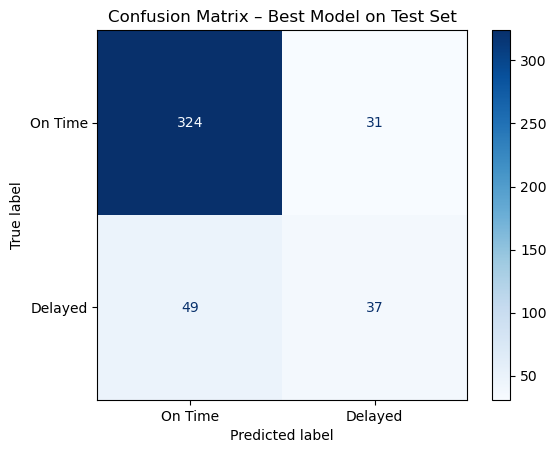

Exception ignored in: <function ResourceTracker.__del__ at 0x1065f9bc0>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x103235bc0>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x106ce5bc0>
Traceback (most recent call last

In [44]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

y_test_pred = global_best_pipeline.predict(X_test)

cm = confusion_matrix(y_test, y_test_pred)

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=["On Time", "Delayed"]
)

disp.plot(cmap="Blues")
plt.title("Confusion Matrix – Best Model on Test Set")
plt.show()